In [1]:
# --------------------------------------------------------- Global Variables & Paths
# region
# @title Global Variables & Paths { display-mode: "form" }


# --------------- vscode
VS_CODE_RAW_DATA_SET_PATH = '../dogs-vs-cats/data/PetImages' # modify per data set
VS_CODE_CLEAN_DATA_SET_PATH = '../dogs-vs-cats/data/clean_data'

# --------------- kaggle
KAGGLE_RAW_DATA_SET_PATH = '/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages' # modify per data set
KAGGLE_CLEAN_DATA_SET_PATH = '/kaggle/working/clean_data'


# --------------- colab
KAGGLE_CRED_PATH = '/content/gdrive/MyDrive/Bachelor/kaggle'
KAGGLE_DATA_SET_NAME = 'karakaggle/kaggle-cat-vs-dog-dataset'  # modify per data set

COLAB_RAW_DATA_SET_PATH = '/content/kaggle_data/kagglecatsanddogs_3367a/PetImages'  # modify the part after (kaggle_data) per data set
COLAB_CLAEN_DATA_SET_PATH = '/content/clean_data'

EPOCHS = 100
DATA_PERCENTAGE_TO_USE = 1
RENAME_CLEAN_DATA = True
COPY_RAW_DATA = True



# endregion

In [2]:
# --------------------------------------------------------- install libraries
# region
# @title install libraries { display-mode: "form" }

# %pip install --upgrade pillow pydrive2
# endregion

In [3]:
# --------------------------------------------------------- imports
# region
# @title imports { display-mode: "form" }

import os
import time
import uuid
import random
import warnings
import shutil
import zipfile
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

print("imports done")

# endregion



imports done


In [4]:
# --------------------------------------------------------- functions
# region
# @title functions {display-mode: "form"}

raw_data_path = None
clean_data_path = None

def get_environment():
    if 'COLAB_GPU' in os.environ:
        return 'Google Colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'Kaggle'
    elif 'VSCODE_PID' in os.environ:
        return 'VS Code'
    else:
        return 'Unknown environment'

def do_colab_staff():

    from google.colab import drive
    drive.mount('/content/gdrive')

    # storing kaggle credentials
    os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_CRED_PATH

    !kaggle datasets download -d {KAGGLE_DATA_SET_NAME}
    print("downloaded dataset" ,KAGGLE_DATA_SET_NAME )

    ! mkdir kaggle_data

    downloaded_zip_name = f"{KAGGLE_DATA_SET_NAME.split('/')[-1]}.zip" # the !kaggle datasets download command will download the zip file with the same name as the dataset name
    extract_folder_path = 'kaggle_data'
    with zipfile.ZipFile(downloaded_zip_name, 'r') as zip_ref:
         zip_ref.extractall(extract_folder_path)

    global raw_data_path
    raw_data_path = COLAB_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = COLAB_CLAEN_DATA_SET_PATH


def do_kaggle_staff():
    global raw_data_path
    raw_data_path = KAGGLE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = KAGGLE_CLEAN_DATA_SET_PATH

def do_vscode_staff():
    global raw_data_path
    raw_data_path = VS_CODE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = VS_CODE_CLEAN_DATA_SET_PATH

def do_unknown_environment_staff():
    print("This is an unknown environment, please enter the path to the data set folder:")
    global raw_data_path
    raw_data_path = input()

def image_is_ok(image_path):
    with warnings.catch_warnings(record=True) as w:
        try:
            img = Image.open(image_path)
            img.verify()
            if len(w) > 0:  # if any warnings were issued
                return False
            return True
        except (IOError, SyntaxError):
            return False

def copy_clean_files(dirty_dataset_path, destination_folder_path):
    # If the destination directory already exists, remove it and all its contents
    if os.path.exists(destination_folder_path):
        shutil.rmtree(destination_folder_path)
        print(f"removed {destination_folder_path} directory to create a new one...")
    os.makedirs(destination_folder_path)
    for root, dirs, files in os.walk(dirty_dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            if image_is_ok(file_path):
                new_file_path = os.path.join(destination_folder_path, os.path.relpath(file_path, dirty_dataset_path))
                os.makedirs(os.path.dirname(new_file_path) , exist_ok=True)
                shutil.copyfile(file_path, new_file_path)
            else:
                # print(f"file: {file_path} is corrupted & skipped from dataset while copying ")
                 print(f"file: {os.path.relpath(file_path, dirty_dataset_path)} is corrupted & skipped from dataset while copying ")
    print(f"copied files from {dirty_dataset_path} to {destination_folder_path} successfully")

def rename_files(data_set_path):
    all_entities_names = os.listdir(data_set_path)
    print("giving temporary unique names...")
    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        for filename in os.listdir(entity_path):
            temp_filename = str(uuid.uuid4()) + ".jpg"  # generate a unique filename
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, temp_filename)
            os.rename(source, destination)
    # ----------------------------------------------------------------------------------------------------
    print("renaming...")
    # then rename every file in every folder in the given path

    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        i = 1
        for filename in os.listdir(entity_path):
            entity_name = entity_name.lower()
            new_filename = entity_name + '.' + str(i) + ".jpg"
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, new_filename)
            os.rename(source, destination)
            i += 1
    print("done renaming !")

def find_image_folder_after_extracting_zip(extracted_folder_path):
    for root, dirs, files in os.walk(extracted_folder_path):
        # check if the current directory contains image files
        if any(fname.lower().endswith(('.png', '.jpg', '.jpeg')) for fname in files):
            return os.path.dirname(root)
    return None
print("functions done")



# endregion



functions done


In [5]:
# --------------------------------------------------------- doing specific-environment things
# region
# @title doing specific-environment things {display-mode: "form"}

# test if the GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus if gpus else "No GPU available, using CPU instead.")

raw_data_path = None
environment_type = get_environment()
print(f'Environment: {environment_type}')
if environment_type == 'Google Colab':
    do_colab_staff()
elif environment_type == 'Kaggle':
    do_kaggle_staff()
elif environment_type == 'VS Code':
    do_vscode_staff()
else:
    do_unknown_environment_staff()

print("raw data set path:", raw_data_path)
assert os.path.exists(raw_data_path), ' wrong path for data set !'
print("clean data set path:", clean_data_path)


print("doing specific-environment things done")

# endregion




[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Environment: Google Colab
Mounted at /content/gdrive
 99% 780M/787M [00:15<00:00, 69.5MB/s]
100% 787M/787M [00:15<00:00, 53.9MB/s]
downloaded dataset karakaggle/kaggle-cat-vs-dog-dataset
raw data set path: /content/kaggle_data/kagglecatsanddogs_3367a/PetImages
clean data set path: /content/clean_data
doing specific-environment things done


In [6]:
# --------------------------------------------------------- data preparation
# region
# @title data preparation {display-mode: "form"}

start_time = time.time()

print("raw data path:", raw_data_path)
parent_dir = os.path.dirname(raw_data_path)
print("raw data parent dir:", parent_dir)
print("clean data path:", clean_data_path)

if(COPY_RAW_DATA):
    copy_clean_files(raw_data_path, clean_data_path)
if(RENAME_CLEAN_DATA):
    rename_files(clean_data_path)
ready_data_path = clean_data_path

print("we will only use ", DATA_PERCENTAGE_TO_USE * 100, "% of the data")
print("data preparation done")


# endregion



raw data path: /content/kaggle_data/kagglecatsanddogs_3367a/PetImages
raw data parent dir: /content/kaggle_data/kagglecatsanddogs_3367a
clean data path: /content/clean_data
file: Dog/9041.jpg is corrupted & skipped from dataset while copying 
file: Dog/Thumbs.db is corrupted & skipped from dataset while copying 
file: Cat/Thumbs.db is corrupted & skipped from dataset while copying 
copied files from /content/kaggle_data/kagglecatsanddogs_3367a/PetImages to /content/clean_data successfully
giving temporary unique names...
renaming...
done renaming !
we will only use  100 % of the data
data preparation done


In [7]:
# 1 --------------------------------------------------------- Loading Images in a Dataframe
# region
# @title 1 - Loading Images in a Dataframe { display-mode: "form" }

all_entities_names = os.listdir(ready_data_path)
print("all entities names:", all_entities_names)
filenames = []
original_data_set_size = 0
for entity_name in all_entities_names:
    entity_path = os.path.join(ready_data_path, entity_name)
    entity_filenames = [file_name for file_name in os.listdir(entity_path)]
    original_data_set_size += len(entity_filenames)
    random.shuffle(entity_filenames)
    entity_filenames = entity_filenames[:int(len(entity_filenames) * DATA_PERCENTAGE_TO_USE)]
    filenames.extend([os.path.join(entity_name, file_name) for file_name in entity_filenames])

print(f"selected data set size = {DATA_PERCENTAGE_TO_USE} * {original_data_set_size} = {len(filenames)}")
file_labels = [x.split(os.sep)[0] for x in filenames]
data = pd.DataFrame({"filename": filenames, "label": file_labels})

print("Loading Images in a Dataframe done")
# endregion


all entities names: ['Dog', 'Cat']
selected data set size = 1 * 24958 = 24958
Loading Images in a Dataframe done


In [8]:
# 2 --------------------------------------------------------- Train Test Split
# region
# @title 2 - Train Test Split { display-mode: "form" }

lables = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=lables, random_state = 42)
label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print(" ")
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)
print(" ")

# endregion


 
The shape of train data (19966, 2)
The shape of test data (2496, 2)
The shape of validation data (2496, 2)
 


In [9]:
# 3 --------------------------------------------------------- Creating Image Data Generator
# region
# @title 3 - Creating Image Data Generator  { display-mode: "form" }

image_size = 128
image_channel = 3
bat_size = 32

# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying image data gernerator to train and test data

# print("all entities path : ", all_entities_path)
# print ("X_train head: ", X_train.head())
# print ("X_val head: ", X_val.head())
# print ("X_test head: ", X_test.head())

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                class_mode='categorical')
# print("tain generator indicise : " ,train_generator.class_indices)
# print("corrupted files : ", corrupted_file_paths)
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

print("Creating Image Data Generator done")

# endregion



Found 19966 validated image filenames belonging to 2 classes.
Found 2496 validated image filenames belonging to 2 classes.
Found 2496 validated image filenames belonging to 2 classes.
Creating Image Data Generator done


In [10]:
# 4 --------------------------------------------------------- Deep Learning Model
# region
# @title 4 - Deep Learning Model { display-mode: "form" }

model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))
# model.summary()

print("Deep Learning Model done")

# endregion



Deep Learning Model done


In [11]:
# 5 --------------------------------------------------------- Callbacks
# region
# @title 5 - Callbacks { display-mode: "form" }
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

print("Callbacks done")

# endregion


Callbacks done


In [12]:
# 6 --------------------------------------------------------- Model Compilation
# region
# @title 6 - Model Compilation { display-mode: "form" }

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

print("Model Compilation done")

# endregion

#

Model Compilation done


In [13]:
# 7 --------------------------------------------------------- Model Fitting
# region
# @title 7 - Model Fitting { display-mode: "form" }

print("x_train length: ",len(X_train))
print("x_test length: ",len(X_test))
print("batch size: ",bat_size)
print("steps_per_epoch: ",len(X_train) , " // " , bat_size , " = " , len(X_train) // bat_size)
print("validation_steps: ",len(X_test) , " // " , bat_size , " = " , len(X_test) // bat_size)
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = EPOCHS,
                    # data generator must generate at least steps_per_epochs * epochs batches

                    steps_per_epoch = len(X_train) // bat_size,
                    validation_steps = len(X_test) // bat_size,
                   )

print("Model Fitting done")
# endregion

#

x_train length:  19966
x_test length:  2496
batch size:  32
steps_per_epoch:  19966  //  32  =  623
validation_steps:  2496  //  32  =  78
Epoch 1/100
623/623 [==============================] - 148s 220ms/step - loss: 0.6858 - accuracy: 0.6590 - val_loss: 0.6396 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 2/100
623/623 [==============================] - 131s 210ms/step - loss: 0.5115 - accuracy: 0.7499 - val_loss: 0.4610 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 3/100
623/623 [==============================] - 135s 216ms/step - loss: 0.4329 - accuracy: 0.8007 - val_loss: 0.5247 - val_accuracy: 0.7636 - lr: 0.0010
Epoch 4/100
623/623 [==============================] - 135s 217ms/step - loss: 0.3911 - accuracy: 0.8231 - val_loss: 0.3661 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 5/100
623/623 [==============================] - 133s 213ms/step - loss: 0.3544 - accuracy: 0.8394 - val_loss: 0.7309 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 6/100
623/623 [==============================] - ETA: 0

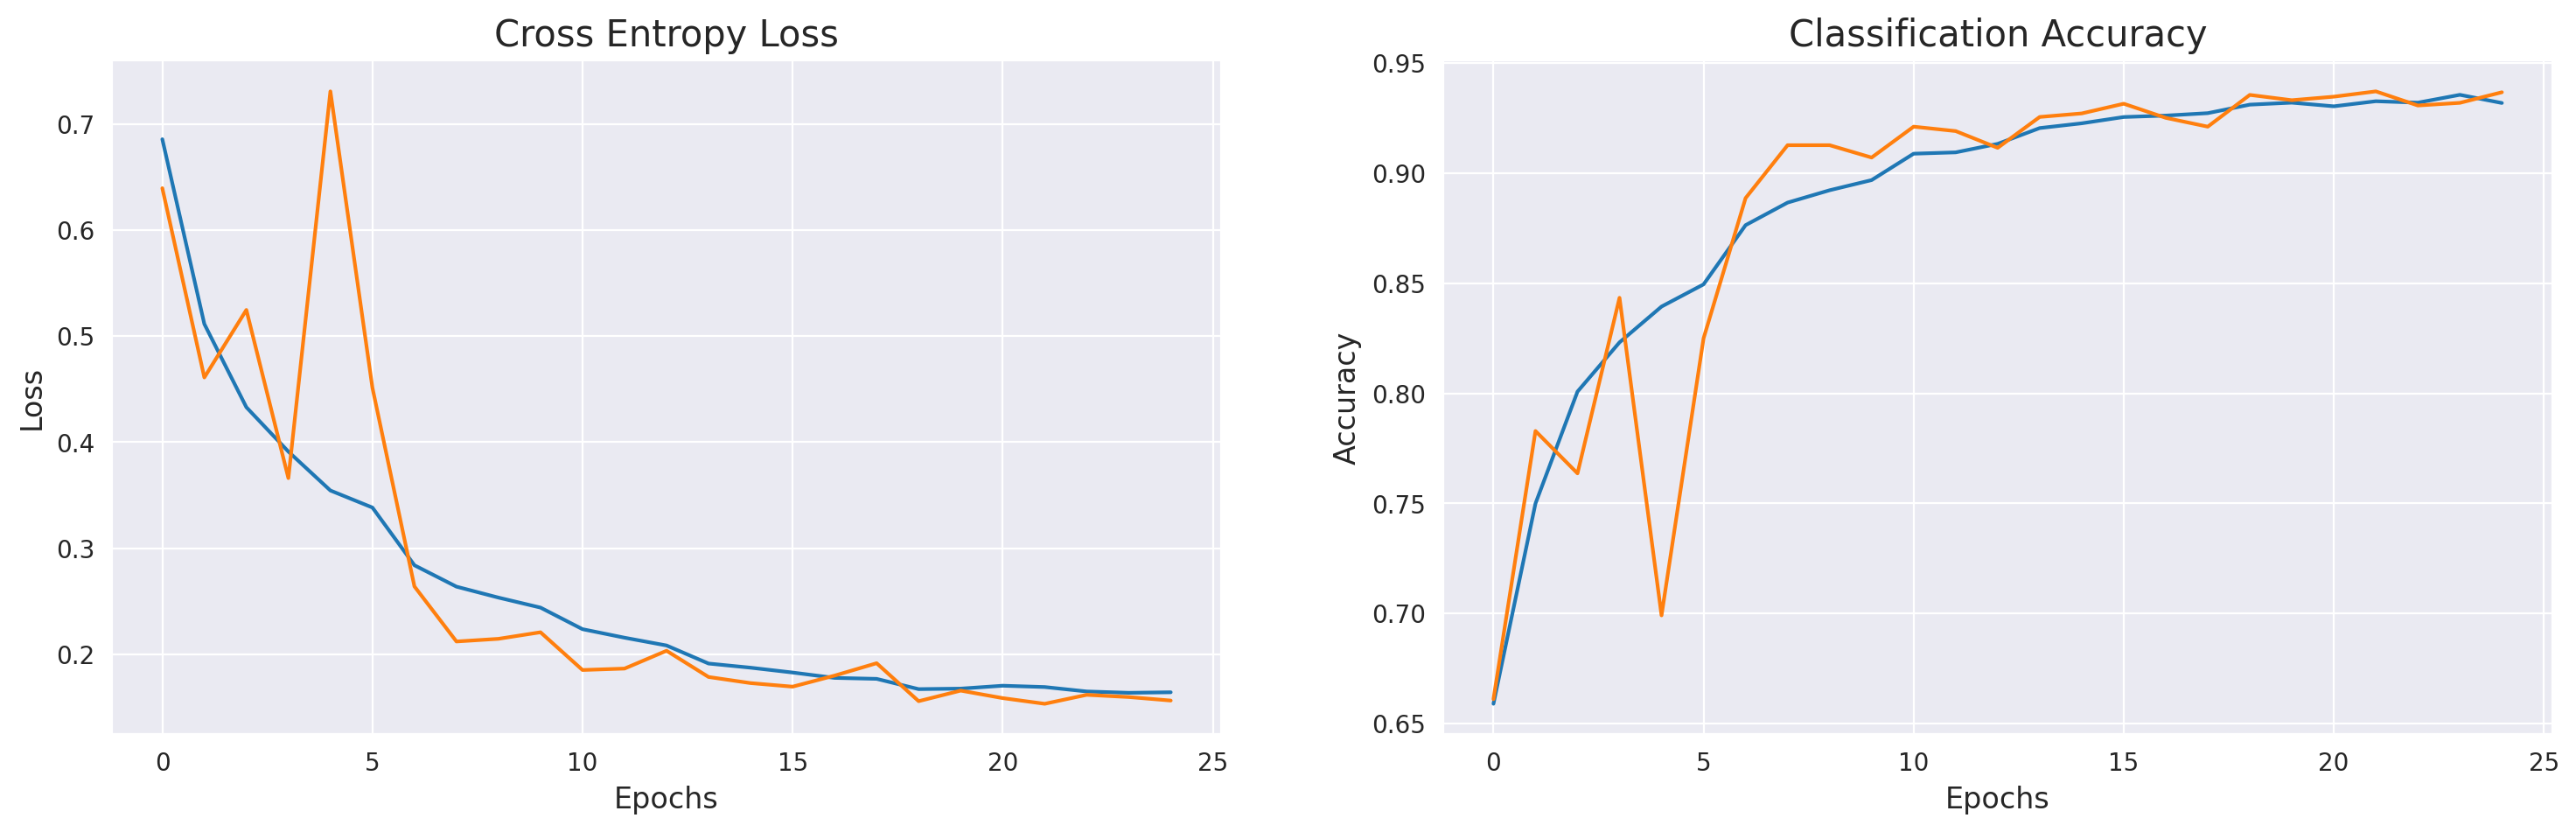

Plot the results done


In [14]:
# 8 --------------------------------------------------------- Plot the results
# region
# @title 8 - Plot the results { display-mode: "form" }
# plots for accuracy and Loss with epochs

error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show(block=False)  # hosain : prevent the popup

print("Plot the results done")

# endregion

#

In [15]:
# 9 --------------------------------------------------------- Evaluation
# region
# @title 9 - Evaluation { display-mode: "form" }
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

#  endregion

#

The accuracy of the model for training data is: 95.46729326248169
The Loss of the model for training data is: 0.11597277969121933
The accuracy of the model for validation data is: 93.70993375778198
The Loss of the model for validation data is: 0.15316006541252136


In [16]:
# 10 --------------------------------------------------------- save the model
# region
# @title 10 - save the model { display-mode: "form" }
model.save("model.keras")

print("Model saved")
# endregion

#

Model saved


In [17]:
# 11 --------------------------------------------------------- Prediction
# region
# @title 11 - Prediction { display-mode: "form" }
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

# endregion

#

The accuracy of the model for testing data is: 93.70993375778198
The Loss of the model for testing data is: 0.14410889148712158


In [18]:
# 12 --------------------------------------------------------- Classification Report
# region
# @title 12 - Classification Report { display-mode: "form" }

print("all entities names:", all_entities_names)
print(classification_report(y_true, y_pred,target_names=all_entities_names))

# endregion

#

all entities names: ['Dog', 'Cat']
              precision    recall  f1-score   support

         Dog       0.93      0.95      0.94      1249
         Cat       0.95      0.93      0.94      1247

    accuracy                           0.94      2496
   macro avg       0.94      0.94      0.94      2496
weighted avg       0.94      0.94      0.94      2496



Normalized Confusion Matrix: 
 [[0.94715773 0.05284227]
 [0.07297514 0.92702486]]


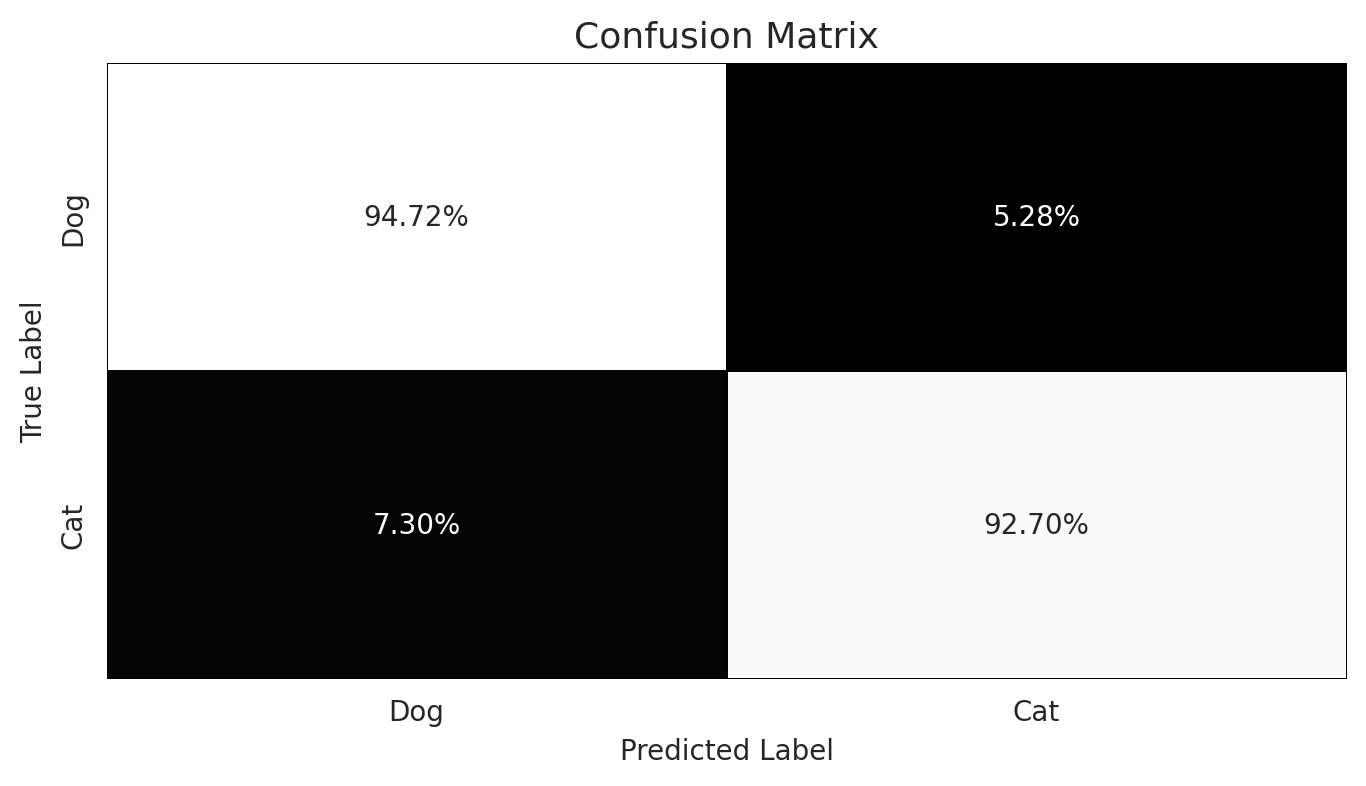

In [19]:
# 13 --------------------------------------------------------- Confusion Matrix
# region
# @title 13 - Confusion Matrix { display-mode: "form" }

# Normalize the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

print("Normalized Confusion Matrix: \n", confusion_mtx)

f, ax = plt.subplots(figsize=(8, 4), dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap="gist_yarg_r", linecolor="black", fmt='.2%', ax=ax, cbar=False, xticklabels=all_entities_names, yticklabels=all_entities_names)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.show()
# endregion



In [20]:
# 14 --------------------------------------------------------- Execution Time
# region
# @title 14 - Execution time  { display-mode: "form" }

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")
# endregion



Execution time: 3564.3743410110474 seconds


In [21]:
# --------------------------------------------------------- reference codes
# region
#  @title  reference codes { display-mode: "form" }

# from google.colab import drive
# drive.mount('/content/gdrive')

# import zipfile
# import os
# extract_source = "/content/gdrive/My Drive/GUC Bachelor : Arabic Image-to-Letters Script Recognition/data set/data set 2.zip"
# extract_destination = "/content/extracted_from_drive"
# zip_ref = zipfile.ZipFile(extract_source, 'r')
# print("extracting...")
# zip_ref.extractall(extract_destination)
# extracted_folder_name = os.listdir(extract_destination)[0]
# zip_ref.close()
# print("extracted files from drive to colab successfully !")
# all_entities_path = os.path.join(extract_destination, extracted_folder_name)


# def get_corrupted_files_paths(all_entities_path):
#     all_entities_names = os.listdir(all_entities_path)
#     corrupted_file_paths = set()
#     print("\nVerifying all files are non-corrupted images...")
#     for entity_name in all_entities_names:
#         entity_path = os.path.join(all_entities_path, entity_name)
#         for filename in os.listdir(entity_path):
#             file_path = os.path.join(entity_path, filename)
#             if not image_is_ok(file_path):
#                 print(f"File {file_path} is corrupted and will be skipped.")
#                 corrupted_file_paths.add(file_path)
#     print("Your data is ok." if not corrupted_file_paths else "Done reporting error files.")
#     return corrupted_file_paths

